In [1]:
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
from scipy.optimize import linprog

## 5.2.3 Computing equilibria: the sequence form

A sequence is a set of actions that a player can take in order to get to some node $h$ from the root. In a perfect recall game, there will be one sequence per player per node. A sequence only covers your own actions. A reward function is also added with the amount each player gains if they both play their sequences. Consider this game:

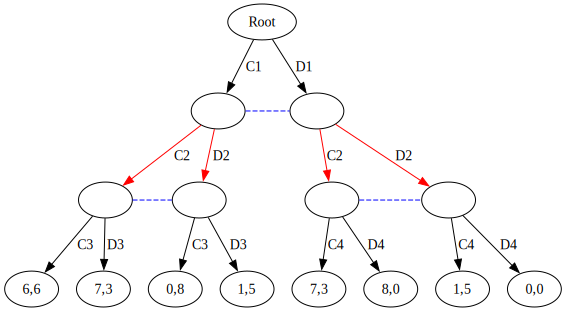

In [2]:
graph1 = Digraph()
graph1.node('Root', 'Root')
graph1.node('A', '')
graph1.node('B', '')
graph1.edge('Root', 'A','C1',color="black")
graph1.edge('Root', 'B','D1',color="black")
graph1.edge('A', 'B','',color="blue",style="dashed",dir="none")
with graph1.subgraph() as same_rank:
    same_rank.attr(rank='same')
    same_rank.node('A')
    same_rank.node('B')
graph1.node('C', '')
graph1.node('D', '')
graph1.edge('A', 'C','C2',color="red")
graph1.edge('A', 'D','D2',color="red")
graph1.node('E', '')
graph1.node('F', '')
graph1.edge('B', 'E','C2',color="red")
graph1.edge('B', 'F','D2',color="red")
graph1.edge('C', 'D','',color="blue",style="dashed",dir="none")
graph1.edge('E', 'F','',color="blue",style="dashed",dir="none")
with graph1.subgraph() as same_rank:
    same_rank.attr(rank='same')
    same_rank.node('C')
    same_rank.node('D')
    same_rank.node('E')
    same_rank.node('F')
graph1.node('G', '6,6')
graph1.node('H', '7,3')
graph1.edge('C', 'G','C3',color="black")
graph1.edge('C', 'H','D3',color="black")
graph1.node('I', '0,8')
graph1.node('J', '1,5')
graph1.edge('D', 'I','C3',color="black")
graph1.edge('D', 'J','D3',color="black")
graph1.node('K', '7,3')
graph1.node('L', '8,0')
graph1.edge('E', 'K','C4',color="black")
graph1.edge('E', 'L','D4',color="black")
graph1.node('M', '1,5')
graph1.node('N', '0,0')
graph1.edge('F', 'M','C4',color="black")
graph1.edge('F', 'N','D4',color="black")
display(graph1)

The below table shows the possible sequences and rewards, where $\theta$ is the root. Where the combination of sequences doesn't lead to a leaf the value is 0 and colored in gray.

$
\begin{array}{c|ccc}
\text{} & \emptyset & \text{C2} & \text{D2} \\
\hline
\emptyset & \textcolor{gray}{0,0} & \textcolor{gray}{0,0} & \textcolor{gray}{0,0} \\
\text{C1} & \textcolor{gray}{0,0} & \textcolor{gray}{0,0} & \textcolor{gray}{0,0} \\
\text{D1} & \textcolor{gray}{0,0} & \textcolor{gray}{0,0} & \textcolor{gray}{0,0} \\
\text{C1,C3} & \textcolor{gray}{0,0} & 6,6 & 0,8 \\
\text{C1,D3} & \textcolor{gray}{0,0} & 7,3 & 1,5 \\
\text{D1,C4} & \textcolor{gray}{0,0} & 7,3 & 1,5 \\
\text{D1,D4} & \textcolor{gray}{0,0} & 8,0 & 0,0 \\
\end{array}
$

In practice this means we can use a smaller table and only store values for the leaf nodes. The full mixed strategy space (with a lot of redundancy!) is:

$
\begin{array}{c|cc}
\text{} & \text{C2} & \text{D2} \\
\hline
\text{C1,C3,C4} & 6,6 & 0,8 \\
\text{C1,C3,D4} & 6,6 & 0,8 \\
\text{C1,D3,C4} & 7,3 & 1,5 \\
\text{C1,D3,D4} & 7,3 & 1,5 \\
\text{D1,C3,C4} & 7,3 & 1,5 \\
\text{D1,D3,C4} & 7,3 & 1,5 \\
\text{D1,C3,D4} & 8,0 & 0,0 \\
\text{D1,D3,D4} & 8,0 & 0,0 \\
\end{array}
$

We can now define a **realisation plan**, as a function which assigns each sequence a probability. The only condition is that the sum of the probabilities of all sequences which "extend" (i.e., add a single action) to a given sequence must equal the probability of that sequence. In other words as you go up the tree you need to add the probabilities. 

The following is a possible realisation plan:

$
\begin{array}{c|c}
\text{} & p \\
\hline
\emptyset & 1 \\
\text{C1} & \frac{1}{3} \\
\text{D1} & \frac{2}{3} \\
\text{C1,C3} & \frac{1}{9} \\
\text{C1,D3} & \frac{2}{9} \\
\text{D1,C4} & \frac{1}{3} \\
\text{D1,D4} & \frac{1}{3} \\
\end{array}
$

Because each node corresponds to only one sequence the number of constraints in the realisation plan is only equal to the number of constraints.

#### Computing best responses in two-player games

Computing the best response to the other player's realisation plan is a fairly straightforward linear program, where $\sigma_1$ and $\sigma_2$ refer to the sequences of players, and $r_1(\sigma_1)$ is the probability of choosing the sequence, $g_1(\sigma_1,\sigma_2)$ is player 1's reward for playing their strategy, and $I_1$ is all the information sets for player 1.

$$
\begin{align*}
\text{maximise} \quad & \sum_{\sigma_1} \big( \sum_{\sigma_2} g_1(\sigma_1,\sigma_2)r_2(\sigma_2) \big) r_1(\sigma_1) \\
\text{subject to} \quad & r_1(\emptyset)=1 \\
\text{} \quad & \sum_{\sigma_1^{\prime}\in \text{Extension}(I)} r_1(\sigma_1^{\prime})=r_1(\text{Sequence}_1(I)) \quad \forall I\in I_1 \\
\text{} \quad & r_1(\sigma_1)\geq 0 \\
\end{align*}
$$

Looking at the example above let's say player 2 has a realisation plan which is always $C2$. Then we have this linear program:

In [3]:
c = np.array([0,0,0,3,7,7,8])
A_eq = np.array([
    [1,0,0,0,0,0,0], # root equals 1
    [1,-1,-1,0,0,0,0], # C1 or D1 has to equal Root
    [0,1,0,-1,-1,0,0], # C3 or D3 has to equal C1
    [0,0,1,0,0,-1,-1], # C4 or D4 has to equal D1
])
b_eq = np.array([1,0,0,0])
result = linprog(-c, A_eq=A_eq, b_eq=b_eq)
result["x"]

array([ 1.,  0.,  1.,  0., -0.,  0.,  1.])

Unsuprisingly, the choice is D1,D4.

We can also take the dual of this problem, which gives a slightly different interpretation. In the dual the variables represent the value of each information set, weighed by the probabilities above it. This is a bit hard to explain. The leaf nodes are just the reward function. Every other variable is then at least the sum of the rewards of the nodes below:

$$
\begin{align*}
\text{minimise} \quad v_0 \\
\text{subject to} \quad & V_I(\sigma_1) - \sum_{\text{child}\in \text{extension}(\sigma_1)} V_I(\text{child}) \geq \sum_{\sigma_2} g_1(\sigma_1,\sigma_2)r_2(\sigma_2) \quad \forall \sigma_1 \\
\end{align*}
$$

In [4]:
c = np.array([1,0,0,0,0,0,0])
A_gr = np.array([
    [1,-1,-1,0,0,0,0],
    [0,1,0,-1,-1,0,0],
    [0,0,1,0,0,-1,-1],
    [0,0,0,1,0,0,0],
    [0,0,0,0,1,0,0],
    [0,0,0,0,0,1,0],
    [0,0,0,0,0,0,1],
])
b_gr = np.array([0,0,0,6,7,7,8])
result = linprog(c, -A_gr, -b_gr)
result["x"]

array([28., 13., 15.,  6.,  7.,  7.,  8.])

I think this is right? Note that if we apply the strategy corresponding to the highest score at each node we get the same answer.

Unfortunately, the problem of finding an equilibrium remains difficult to solve even with these changes. There is a more general version of the Lemke-Howson algorithm (called the Lemke algorithm) which solves the problem on a sequence-form game, and is exponentially faster than the usual method for a normal-form game. 

## 5.2.4 Sequential equilibria

From before we had the idea of a subgame equilibria. Does the same idea apply here? Well, kindof. Consider this:

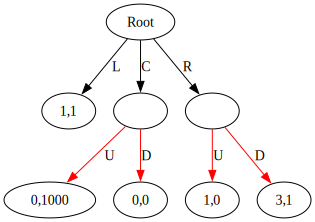

In [5]:
graph2 = Digraph()
graph2.node('Root', 'Root')
graph2.node('L', '1,1')
graph2.node('C', '')
graph2.node('R', '')
graph2.edge('Root', 'L','L',color="black")
graph2.edge('Root', 'C','C',color="black")
graph2.edge('Root', 'R','R',color="black")
graph2.node('U1', '0,1000')
graph2.node('D1', '0,0')
graph2.edge('C', 'U1','U',color="red")
graph2.edge('C', 'D1','D',color="red")
graph2.node('U2', '1,0')
graph2.node('D2', '3,1')
graph2.edge('R', 'U2','U',color="red")
graph2.edge('R', 'D2','D',color="red")
display(graph2)

The payoffs of this are:

$
\begin{array}{c|cc}
\text{} & U & D \\
\hline
\text{L} & 1,1 & 1,1\\
\text{C} & 0,1000 & 0,0\\
\text{R} & 1,0 & 3,1\\
\end{array}
$

Notice that there are two Nash equilibria: LU and RD. This is a bit odd! In truth player 1 would realise if they do R then player 2 will go D, which is better for player 1 than LU. The only true equilibria is then RD. A stronger concept that Nash equilibria is sequential equilibria. Calculating these for extensive-form games involves finding a strategy for both players such that the strategy is optimal given the resulting probabilities in each state.

In other words, at any single decision point (information set) we need to calculate the probabilities of subsequent states, given both strategies, then check that the agent making the decision is unwilling to change their strategy. 

To see an example, let's take the matching pennies problem:

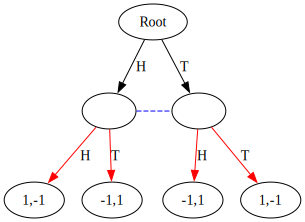

In [6]:
graph3 = Digraph()
graph3.node('Root', 'Root')
graph3.node('H1', '')
graph3.node('T1', '')
graph3.edge('Root', 'H1','H',color="black")
graph3.edge('Root', 'T1','T',color="black")
graph3.edge('H1', 'T1','',color="blue",style="dashed",dir="none")
with graph3.subgraph() as same_rank:
    same_rank.attr(rank='same')
    same_rank.node('H1')
    same_rank.node('T1')
graph3.node('H2', '1,-1')
graph3.node('T2', '-1,1')
graph3.node('H3', '-1,1')
graph3.node('T3', '1,-1')
graph3.edge('H1', 'H2','H',color="red")
graph3.edge('H1', 'T2','T',color="red")
graph3.edge('T1', 'H3','H',color="red")
graph3.edge('T1', 'T3','T',color="red")
display(graph3)

Lets check the strategy where both players go 50:50. We need to make sure that both players are happy with this. To start we can look at player 1's action at the root node. The probabilitiy of each state is derived:

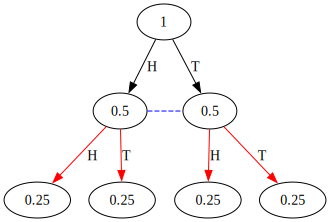

In [9]:
graph4 = Digraph()
graph4.node('Root', '1')
graph4.node('H1', '0.5')
graph4.node('T1', '0.5')
graph4.edge('Root', 'H1','H',color="black")
graph4.edge('Root', 'T1','T',color="black")
graph4.edge('H1', 'T1','',color="blue",style="dashed",dir="none")
with graph4.subgraph() as same_rank:
    same_rank.attr(rank='same')
    same_rank.node('H1')
    same_rank.node('T1')
graph4.node('H2', '0.25')
graph4.node('T2', '0.25')
graph4.node('H3', '0.25')
graph4.node('T3', '0.25')
graph4.edge('H1', 'H2','H',color="red")
graph4.edge('H1', 'T2','T',color="red")
graph4.edge('T1', 'H3','H',color="red")
graph4.edge('T1', 'T3','T',color="red")
display(graph4)

We can now push back the utilities to previous nodes:

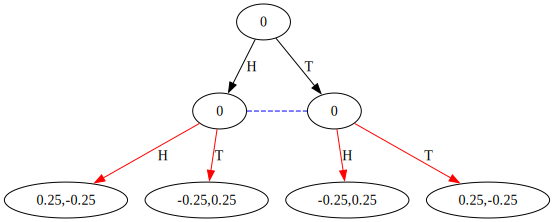

In [10]:
graph5 = Digraph()
graph5.node('Root', '0')
graph5.node('H1', '0')
graph5.node('T1', '0')
graph5.edge('Root', 'H1','H',color="black")
graph5.edge('Root', 'T1','T',color="black")
graph5.edge('H1', 'T1','',color="blue",style="dashed",dir="none")
with graph5.subgraph() as same_rank:
    same_rank.attr(rank='same')
    same_rank.node('H1')
    same_rank.node('T1')
graph5.node('H2', '0.25,-0.25')
graph5.node('T2', '-0.25,0.25')
graph5.node('H3', '-0.25,0.25')
graph5.node('T3', '0.25,-0.25')
graph5.edge('H1', 'H2','H',color="red")
graph5.edge('H1', 'T2','T',color="red")
graph5.edge('T1', 'H3','H',color="red")
graph5.edge('T1', 'T3','T',color="red")
display(graph5)

We can see that player 1 is given the choice between 0 and 0, so has no incentive to change. We can then check player 2's decision in the same way. Player 2 doesn't see player 1's decision, so the probability of the subsequent states remain the same and it's obvious there is no incentive to change here either.